In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq

import numpy as np
import pandas as pd

from squidpy.tl._exp_dist import exp_dist
from squidpy.tl._spatial_de import spatial_de
from squidpy.pl._pl_spatial_de import pl_spatial_de

from scipy.sparse import csr_matrix

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.generalized_estimating_equations import GLM


In [2]:
adata = sc.read_h5ad("C://backup/Bachelorarbeit/LiverAgeing_pp_lowres.h5ad")

Use only one liver sample:

In [4]:
adata = adata[adata.obs["mouse_id"] == "TS5"]

annotate central and portal vein based on umap-spline:

In [3]:
adata.obs["vein_type"] = "lobular_axis"
pv = list(adata[adata.obs["umap_spline"] <= 0.2].obs.index)
cv = list(adata[adata.obs["umap_spline"] >= 0.9].obs.index)
adata.obs.loc[adata.obs.index.isin(pv), "vein_type"]  = "pv"
adata.obs.loc[adata.obs.index.isin(cv), "vein_type"]  = "cv"

central and portal vein markers

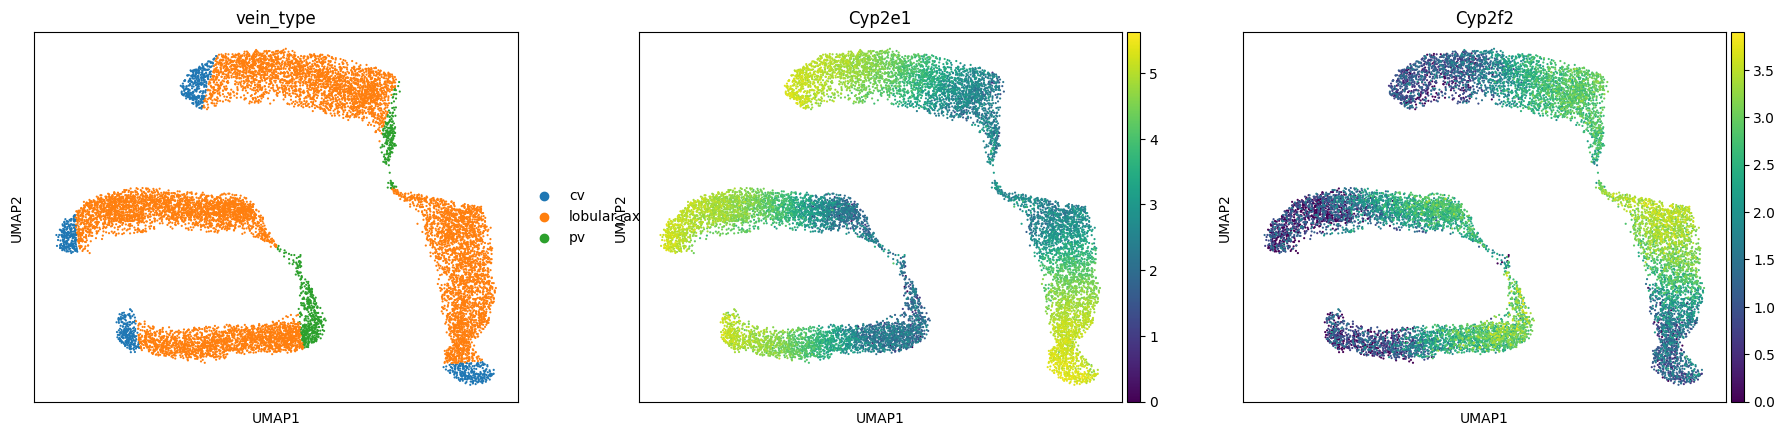

In [13]:
sc.pl.umap(adata, color=["vein_type","Cyp2e1","Cyp2f2"])

restrict to highly variable genes (2000 genes)

In [4]:
adata = adata[:, adata.var.highly_variable]

build design matrix with portal vein as anchor point

In [5]:
exp_dist(adata, groups="pv", cluster_key="vein_type", covariates='age')

c:\Users\laure\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [6]:
adata.obsm["design_matrix"]

,vein_type,pv,pv_raw,age
12x15-37_30_A1,lobular_axis,0.000398,2.076689,old
12x19-37_30_A1,lobular_axis,0.043293,226.091302,old
12x18-37_30_A1,lobular_axis,0.044546,232.635683,old
12x17-37_30_A1,cv,0.043519,227.272159,old
12x16-37_30_A1,lobular_axis,0.002795,14.594595,old
...,...,...,...,...
18x27-37_43_C3,lobular_axis,0.063330,330.731761,young
18x22-37_43_C3,lobular_axis,0.032498,169.715151,young
18x21-37_43_C3,lobular_axis,0.065665,342.920965,young
18x24-37_43_C3,lobular_axis,0.075424,393.889245,young


GAM: gexp ~ vein_type + B(dist_to_pv)

In [7]:
spatial_de(adata, "design_matrix", "pv", covariates="age")

In [8]:
adata.uns["design_matrix_DEGs"]

,gene,p-val,lfc,p-val_adj
1434,Plaur,0.998456,0.000739,0.998456
979,Ighd,0.996935,0.001259,0.997434
1646,Serpina3h,0.996196,-0.000009,0.997193
1376,Pcdhb19,0.986048,0.000585,0.987529
837,Gm48900,0.983924,-0.000414,0.985895
...,...,...,...,...
1273,Neat1,0.000000,-0.883322,0.000000
1645,Serpina1e,0.000000,0.801485,0.000000
37,Abcc2,0.000000,0.125092,0.000000
867,Gpcpd1,0.000000,0.550244,0.000000


In [9]:
pl_spatial_de(adata=adata)

c:\Users\laure\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


significantly spatially DEGs:

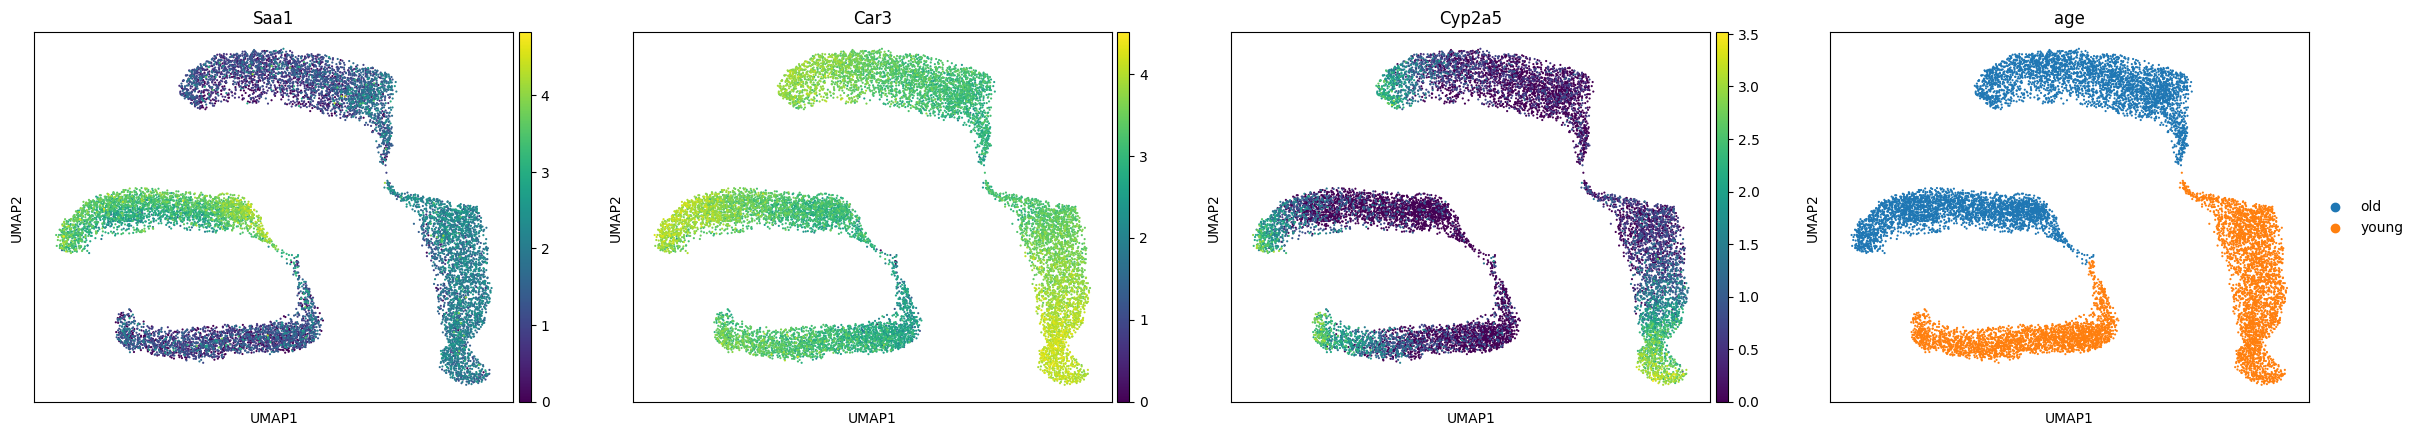

In [12]:
sc.pl.umap(adata, color=["Saa1","Car3","Cyp2a5","age"])

not significantly DEGs:

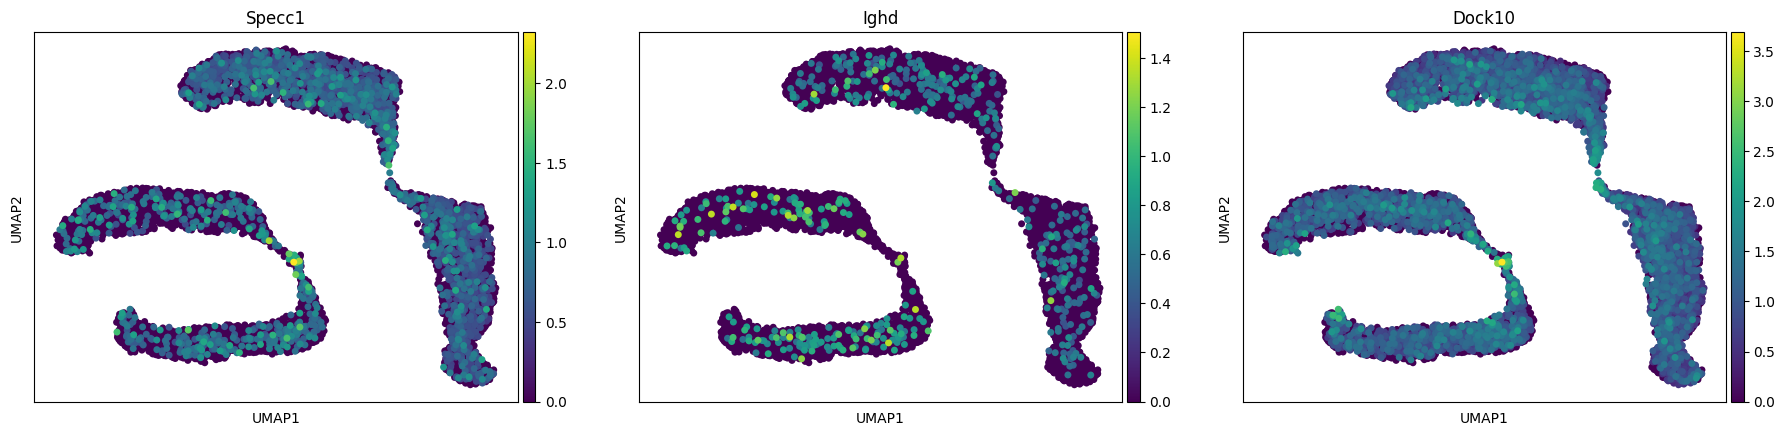

In [18]:
sc.pl.umap(adata, color=["Specc1","Ighd","Dock10"], s=100)

In [22]:
df = adata.obsm["design_matrix"].copy()
df["Cyp2e1"] = sc.get.obs_df(adata, "Cyp2e1").to_numpy()
df = df.rename(columns={'Cyp2e1': 'gene'})
x_spline = df[['pv']]
bs = BSplines(x_spline, df=6, degree=3)
gam_bs = GLMGam.from_formula('gene ~ vein_type', data=df, smoother=bs)
res_bs = gam_bs.fit()
res_bs.summary()
#one categorical value is used as reference (see: https://datascience.stackexchange.com/questions/51787/statsmodels-ols-does-not-include-all-categorical-values)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   gene   No. Observations:                 2623
Model:                         GLMGam   Df Residuals:                     2615
Model Family:                Gaussian   Df Model:                         7.00
Link Function:               identity   Scale:                          1.0013
Method:                         PIRLS   Log-Likelihood:                -3719.6
Date:                Tue, 25 Oct 2022   Deviance:                       2618.4
Time:                        09:42:44   Pearson chi2:                 2.62e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4687
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.8417      0.179     27.019      0.000       4.491       5.193
vein_type[T.lobular_axis]    -1.7549      0.068    -25.992      0.000      -1.887      -1.623
vein_type[T.pv]              -2.9976      0.186    -16.157      0.000      -3.361      -2.634
pv_s0                         0.1875      0.207      0.907      0.364      -0.218       0.593
pv_s1                        -0.5862      0.200     -2.932      0.003      -0.978      -0.194
pv_s2                         0.9916      0.355      2.792      0.005       0.295       1.688
pv_s3                         0.4270      0.435      0.981      0.327      -0.426       1.280
pv_s4                         0.2707      0.508      0.533      0.594      -0.725       1.266
=============================================================================================
"""

save Log-likelihood for later comparison

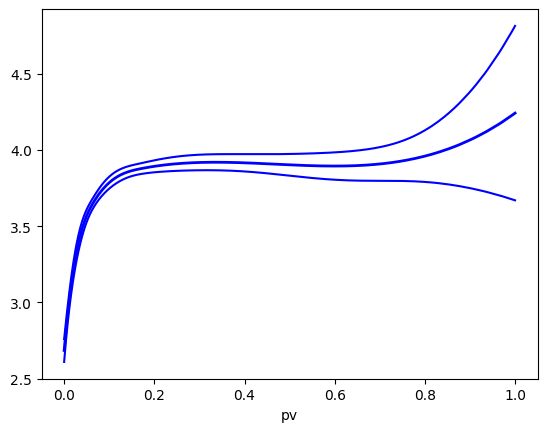

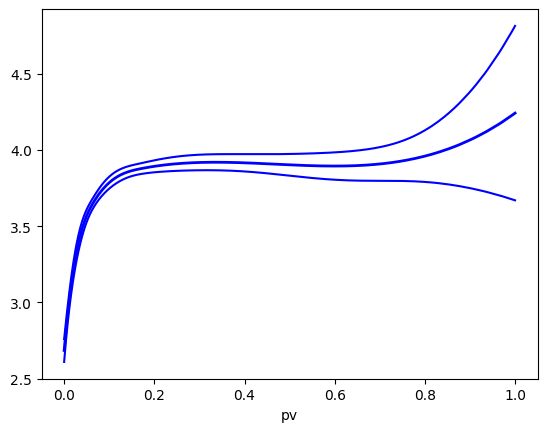

In [17]:
res_bs.plot_partial(smooth_index=0)

In [18]:
ftest = {}
i = 0

for gene in adata.var_names:
    df = adata.obsm["design_matrix"].copy()
    df[gene] = sc.get.obs_df(adata, gene).to_numpy()
    df = df.rename(columns={gene: 'gene'})
    x_spline = df[['pv']]
    bs = BSplines(x_spline, df=6, degree=3)
    gam_bs = GLMGam.from_formula('gene ~ age', data=df, smoother=bs)
    res_bs = gam_bs.fit()
    res_bs.summary()
    A = np.identity(len(res_bs.params))
    A = A[1:,:]
    ftest[gene] = res_bs.f_test(A).pvalue
    print(i)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

significance for central and portal vein markers

In [19]:
ftest["Cyp1a2"] #central vein marker

4.2411000326564844e-279

In [20]:
ftest["Cyp2f2"] #portal vein marker

2.98760304507026e-166

sort by p-value (descending)

In [21]:
ftest_sorted = list(dict(sorted(ftest.items(), key=lambda item: item[1], reverse=True)).items())

entral vein marker is top 38th most significantly (spatially?) differentially expressed gene

In [18]:
ftest_sorted[-38]

('Cyp2f2', 1.3586375893454538e-128)

central vein marker is top 13th most significantly (spatially?) differentially expressed gene

In [19]:
ftest_sorted[-13]

('Cyp1a2', 1.7195308959979085e-183)

top 20 most significant DEGs

In [22]:
ftest_sorted[-100:]

[('Lbp', 0.0),
 ('Lcn2', 0.0),
 ('Lifr', 0.0),
 ('Lrg1', 0.0),
 ('Lrrc28', 0.0),
 ('Malat1', 0.0),
 ('Mcm10', 0.0),
 ('Mgll', 0.0),
 ('Mgst1', 0.0),
 ('Msmo1', 0.0),
 ('Mtss1', 0.0),
 ('Mug-ps1', 0.0),
 ('Mug2', 0.0),
 ('Mup1', 0.0),
 ('Mup11', 0.0),
 ('Mup12', 0.0),
 ('Mup13', 0.0),
 ('Mup14', 0.0),
 ('Mup15', 0.0),
 ('Mup16', 0.0),
 ('Mup17', 0.0),
 ('Mup18', 0.0),
 ('Mup7', 0.0),
 ('Mup9', 0.0),
 ('Neat1', 0.0),
 ('Nipal1', 0.0),
 ('Nmrk1', 0.0),
 ('Nos1ap', 0.0),
 ('Nr1h4', 0.0),
 ('Nrep', 0.0),
 ('Nudt7', 0.0),
 ('Onecut1', 0.0),
 ('Onecut2', 0.0),
 ('Orm1', 0.0),
 ('Orm2', 0.0),
 ('Pah', 0.0),
 ('Paqr9', 0.0),
 ('Pcdh11x', 0.0),
 ('Pfkfb3', 0.0),
 ('Phyh', 0.0),
 ('Pklr', 0.0),
 ('Plcb1', 0.0),
 ('Plcxd2', 0.0),
 ('Plpp3', 0.0),
 ('Ppara', 0.0),
 ('Ppp1r3b', 0.0),
 ('Pygl', 0.0),
 ('Pzp', 0.0),
 ('Rad51b', 0.0),
 ('Rapgef4', 0.0),
 ('Rarres1', 0.0),
 ('Retsat', 0.0),
 ('Rnase4', 0.0),
 ('Rnf125', 0.0),
 ('Saa1', 0.0),
 ('Saa2', 0.0),
 ('Scd1', 0.0),
 ('Scp2', 0.0),
 ('Selenbp2', 

In [23]:
pvals = [x[1] for x in ftest_sorted]

In [24]:
genes = [x[0] for x in ftest_sorted]

In [51]:
pvals[-100:]

[1.064782288330193e-245,
 2.89257551325895e-247,
 4.050438738721495e-248,
 3.185123566050384e-252,
 2.379173680871448e-258,
 2.971460369128915e-259,
 6.744659618154262e-260,
 1.2444637650066442e-260,
 2.3256027095278164e-263,
 1.7033458692314204e-265,
 1.6667303618687552e-265,
 7.252725109837473e-268,
 1.429538056520663e-272,
 4.842496029396486e-274,
 2.72561540702174e-274,
 5.182039399466698e-275,
 2.260643812540238e-276,
 1.7904241704202603e-278,
 4.2411000326564844e-279,
 8.023577941382244e-289,
 8.23167939705814e-295,
 2.418295403782351e-302,
 8.1754383758e-312,
 2.3982714203e-313,
 6.9e-321,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [41]:
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]
adjusted = p_adjust_bh(pvals)
adjusted

array([0.99678122, 0.99377669, 0.99076604, ..., 0.        , 0.        ,
       0.        ])

In [25]:
adjusted = sm.stats.multipletests(pvals, method="bonferroni")

In [27]:
adjusted[1][-100:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
results = {'gene': genes, 'p-values': pvals, 'pvalues_adjusted': adjusted[1]}
results = pd.DataFrame(data=results)
results

,gene,p-values,pvalues_adjusted
0,Fgf10,0.999942,1.0
1,Gm27224,0.999608,1.0
2,4930556J24Rik,0.999377,1.0
3,Gm48779,0.998521,1.0
4,Lbhd1,0.998351,1.0
...,...,...,...
17776,Zbtb7c,0.000000,0.0
17777,mt-Co1,0.000000,0.0
17778,mt-Cytb,0.000000,0.0
17779,mt-Nd5,0.000000,0.0


In [33]:
results.loc[[10000]]

,gene,p-values,pvalues_adjusted
10000,Proser1,2.738999e-07,0.00487


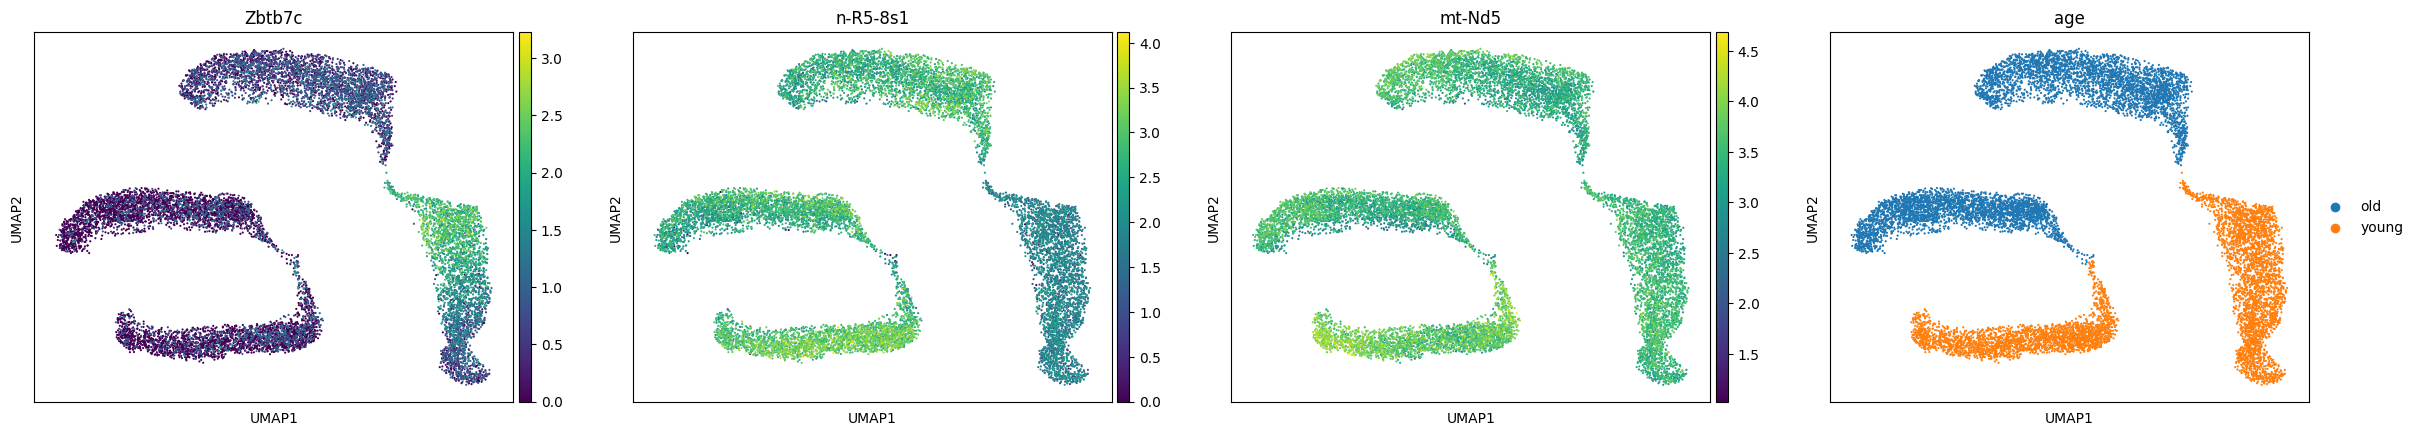

In [30]:
sc.pl.umap(adata, color=["Zbtb7c","n-R5-8s1","mt-Nd5", "age"])

UMAP of some significant DEGs which show spatial dependence (left = central vein, right = portal vein)

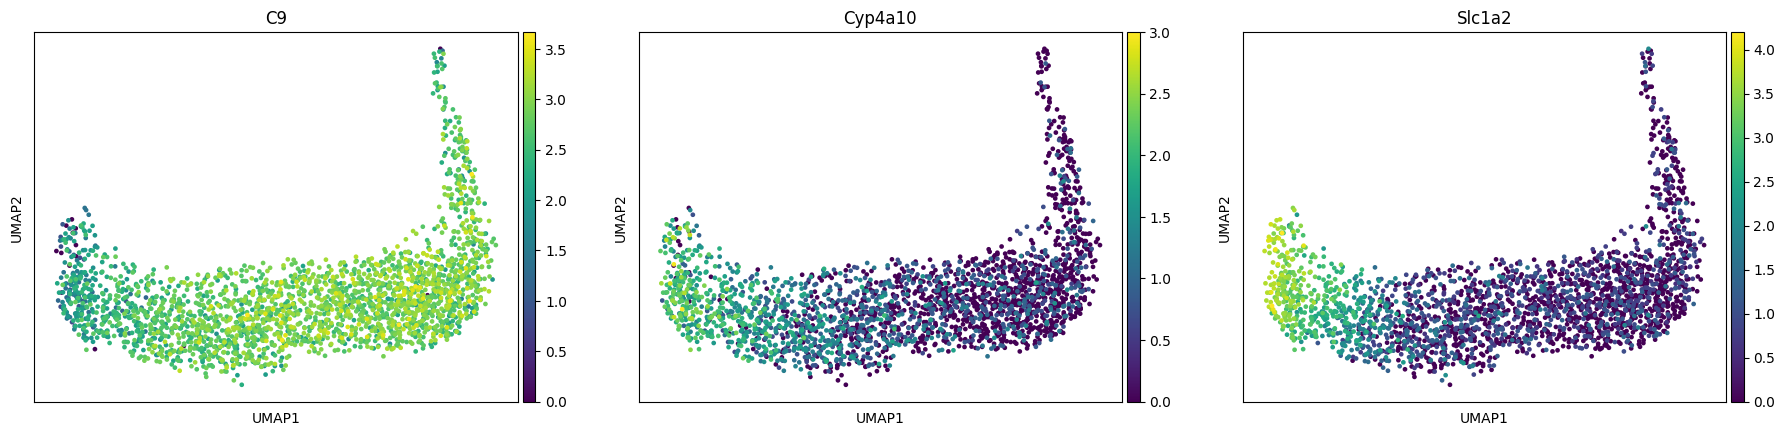

In [21]:
sc.pl.umap(adata, color=["C9","Cyp4a10","Slc1a2"])

In [47]:
ftest_sorted[-1500]

('Cx3cr1', 0.26953311636918426)

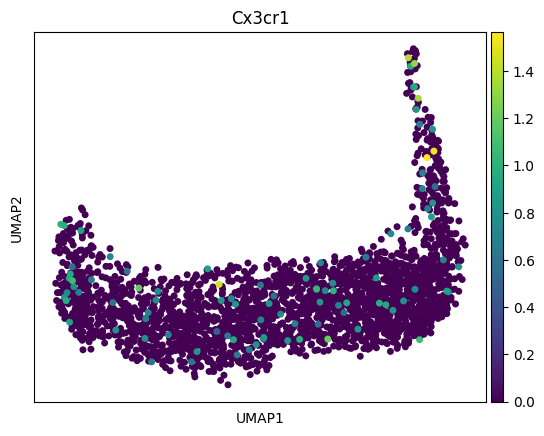

In [49]:
sc.pl.umap(adata, color='Cx3cr1', s=100)

In [22]:
ftest_sorted[-200]

('Sp5', 3.6710373756590845e-29)

Sparsely expressed genes are also picked up if there is a spatial pattern

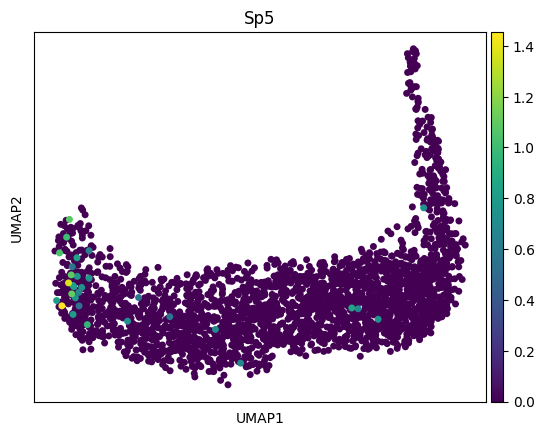

In [23]:
sc.pl.umap(adata, color='Sp5', s=100)

1192 out of 2000 genes regarded as significantly (spatially?) differentially expressed

In [24]:
print(str(ftest_sorted[-1192]) + " " + str(ftest_sorted[-1193]))

('Fxyd3', 0.04916566489181492) ('Lpxn', 0.05017772646799172)


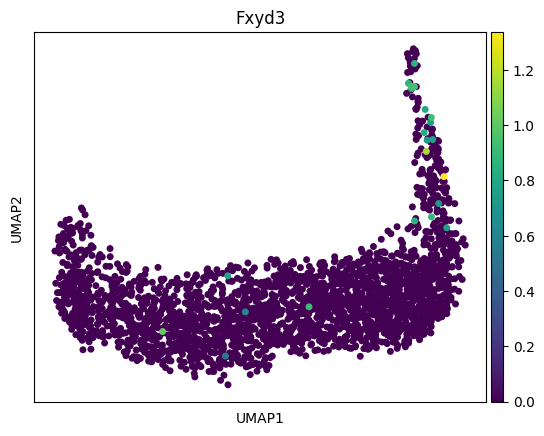

In [25]:
sc.pl.umap(adata, color='Fxyd3', s=100)